# Setup

In [6]:
from io import BytesIO
from shutil import rmtree

import plotly.express as px
import requests
from sklearn.linear_model import LinearRegression
from zipfile import ZipFile

from utils import *

# AAA
**Access Across America (AAA)** from [**Accessibility Observatory**](https://ao.umn.edu/) at the University of Minnesota

* **[Available datasets](https://ao.umn.edu/data/datasets)**
* **[Methodology report for transit access](https://ao.umn.edu/research/america/transit/2019/documents/AccessAcrossAmerica-Transit2019-Methodology.pdf)**
* **[Transit data documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**


## Download AAA data (2022)
After the latest change in their website, the URLs for the different states' access datasets could not be extracted automatically by scraping. They were thus manually collected via their 'handles' (URIs) and stored in a file `data/aaa/urls.csv_2022`.

In [3]:
handles = pd.read_csv('data/aaa/urls_2022.csv').disp()

153 rows x 3 cols; Memory: 0.0 MiB


,mode_,state,handle
,<object>,<object>,<object>
0,Bike,Alabama,2dcf58f6-5a78-4b28-9de1-5fc29c606099


In [5]:
# tmp = mkdir('data/tmp') # temporary data directory
# for _, r in tqdm(handles.iterrows(), total=len(handles)):
#     url = f'https://conservancy.umn.edu/bitstreams/{r.handle}/download'
#     try:
#         with ZipFile(BytesIO(requests.get(url).content)) as z:
#             for level in ['county', 'census_tract', 'block_group', 'block']:
#                 fname = sorted([f.filename for f in z.filelist
#                                 if level in f.filename])[0]
#                 z.extract(fname, tmp)
#                 df = pd.read_csv(tmp / fname, usecols=[
#                     'Census ID', 'Threshold', 'total_jobs' if 
#                     level == 'block' else 'Weighted_average_total_jobs'])
#                 df.columns = ['geoid', 'thresh', 'access']
#                 df = df[df.thresh.isin([15, 30, 45, 60])]
#                 df = df.astype(D(thresh=CAT, access=F32))
#                 df = df.reset_index(drop=1)
#                 outpath = 'data/aaa/2022/{}-{}-{}.parquet'.format(
#                     r.state, r.mode_.lower(), level).replace(' ', '_')
#                 df.to_parquet(outpath, compression='gzip')
#     except Exception as e:
#         print('ERROR:', r.mode_, r.state, level, e)
# rmtree(tmp) # 7m03s

## Compare with our SAA access
SAA: Spatial Access of America

In [5]:
saa = pd.concat([
    pd.read_parquet(f, filters=[('measure', '==', 'Contour'),
                                ('kind', '==', 'Jobs: All'),
                                ('mode', '==', 'Drive')],
                    columns='mode thresh level geoid access'.split())
    .assign(city=f.stem.replace('-', ' ').title())
    for f in tqdm(list(Path('data/access-long').glob('*')))
]).reset_index(drop=1).astype(D(city=CAT)).disp() # 8s

  0%|          | 0/50 [00:00<?, ?it/s]

803,129 rows x 6 cols; Memory: 52.7 MiB


,mode,thresh,level,geoid,access,city
,<category>,<category>,<category>,<object>,<float32>,<category>
0,Drive,15,Tract,13013180103,6590.0,Atlanta


In [6]:
xs = pd.merge(
    filt(aaa.rename(columns=D(access='aaa')), level='BG'),
    filt(saa.rename(columns=D(access='saa')), level='BG'),
    on=['mode', 'thresh', 'geoid']
).disp()

66,784 rows x 6 cols; Memory: 11.2 MiB


,mode,thresh,geoid,aaa,saa,city
,<object>,<object>,<object>,<float32>,<float32>,<category>
0,Drive,30,060014001001,894025.75,1183270.0,San Francisco


In [14]:
# fig = px.scatter(xs, x='aaa', y='saa', symbol='mode',
#                  opacity=0.4, hover_data=['city', 'geoid'],
#                  symbol_sequence=['circle-open', 'square'],
#                  labels=D(saa='SAA (our access)', aaa='AAA access'))
# xmax, ymax = xs.aaa.max(), xs.saa.max()
# fig.add_trace(px.line(x=[0, xmax], y=[0, xmax]).data[0])
# fig.update_layout(width=1100, height=800, font_family='Arial', font_size=16,
#                   xaxis_range=[0, xmax], yaxis_range=[0, ymax])
# fig.update_traces(marker=D(size=8), line=D(color='black'))

In [ ]:
xmax, ymax = xs.aaa.max(), xs.saa.max()
fig = px.scatter(xs, x='aaa', y='saa', color='city', opacity=0.5,
                 labels=D(saa='SAA (our access)', aaa='AAA access'))
fig.add_trace(px.line(x=[0, xmax], y=[0, xmax]).data[0])
fig.update_layout(width=1100, height=800, font_family='Arial', font_size=16,
                  xaxis_range=[0, xmax], yaxis_range=[0, ymax])
fig.update_traces(marker=D(size=5), line=D(color='black'))

5,833 rows x 4 cols; Memory: 0.4 MiB; <Geographic 2D CRS: EPSG:4326>


,geoid,geometry,aaa,saa
,<object>,<geometry>,<float32>,<float32>
0,170438413161,"POLYGON ((-88.207396 41.987326, -88.207276 41....",1152587.25,561793.0


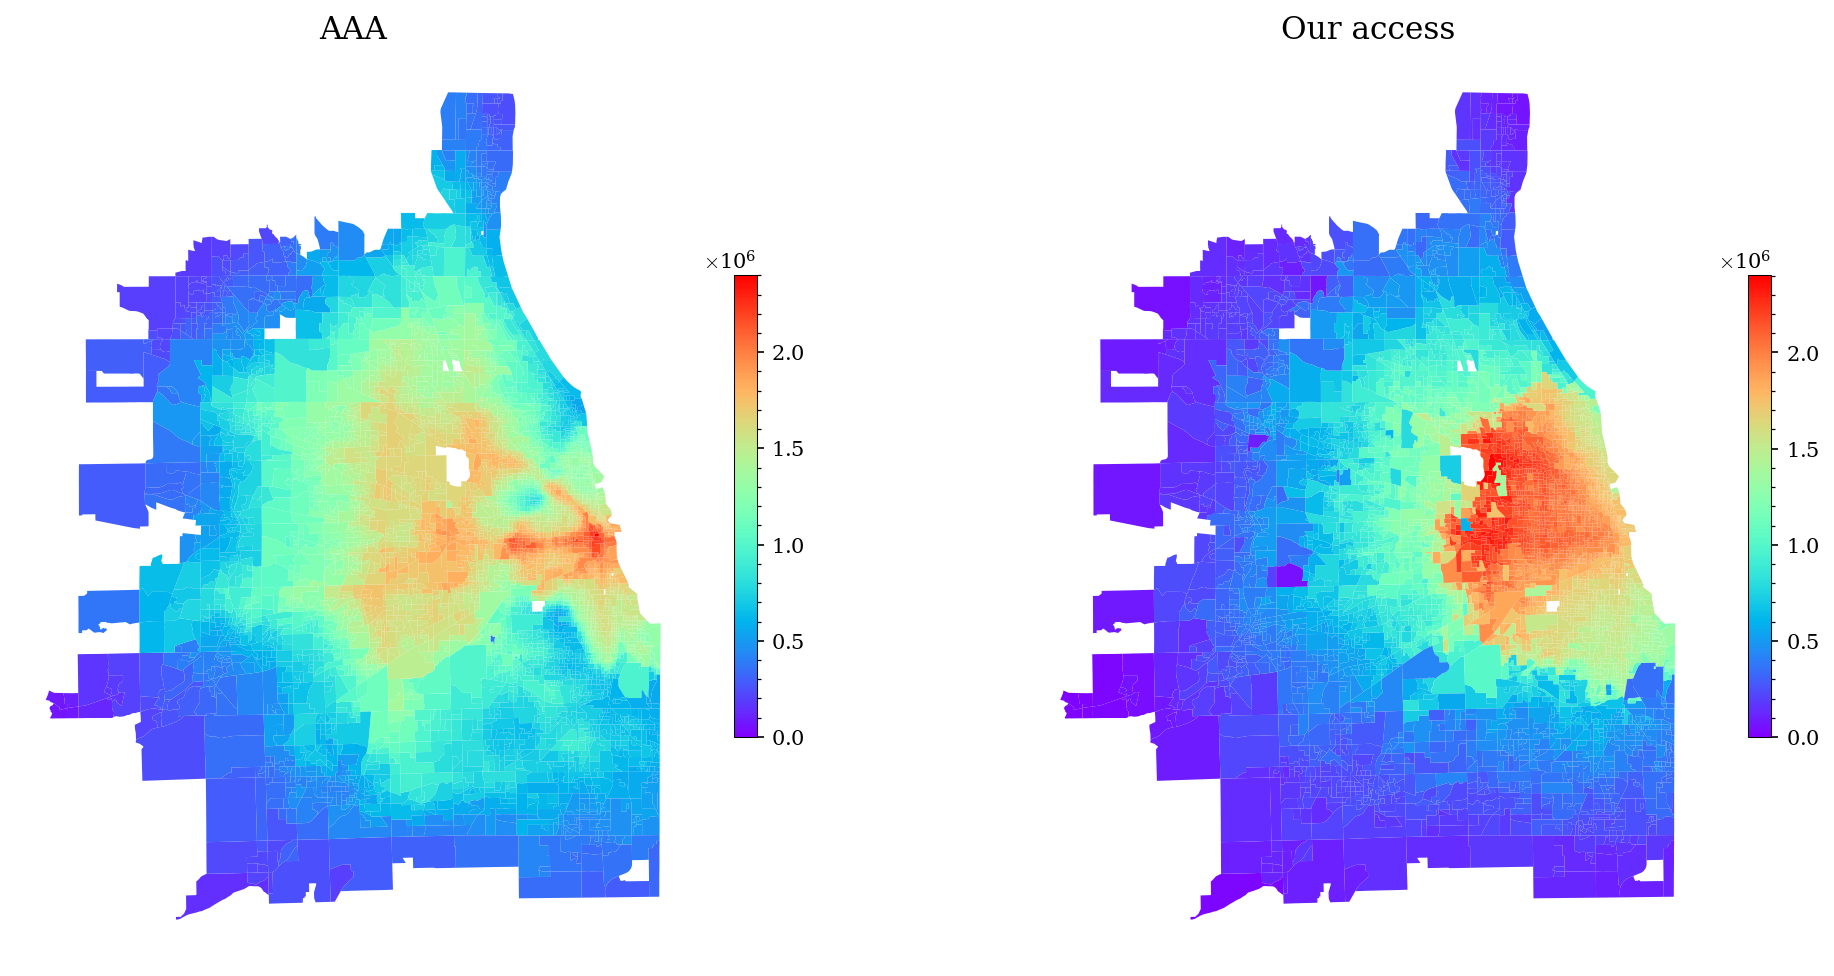

In [17]:
chi = (gpd.read_parquet('data/zones.parquet',
                        filters=[('level', '==', 'BG'), ('city', '==', 'Chicago')],
                        columns=['geoid', 'geometry'])
       .merge(filt(xs, city='Chicago', mode='Drive', thresh='30'))).disp(0)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
for i, (col, label) in enumerate([('aaa', 'AAA'), ('saa', 'Our access')]):
    ax = plot(axes[i], title=label, axoff=1)
    maplot(chi.dropna(), col, ax, bgmap=None, vmin=0)

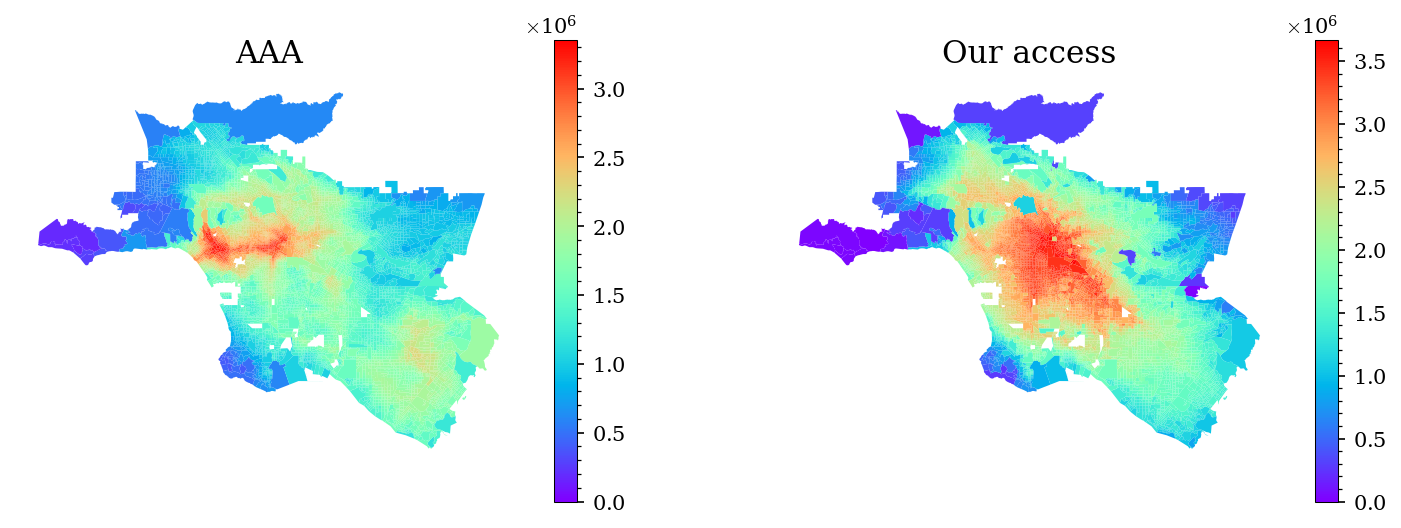

In [19]:
la = (gpd.read_parquet('data/zones.parquet',
                        filters=[('level', '==', 'BG'), ('city', '==', 'Los Angeles')],
                        columns=['geoid', 'geometry'])
       .merge(filt(xs, city='Los Angeles', mode='Drive', thresh='30')))
fig, axes = plt.subplots(1, 2, figsize=(12, 8), dpi=150)
for i, (col, label) in enumerate([('aaa', 'AAA'), ('saa', 'Our access')]):
    ax = plot(axes[i], title=label, axoff=1)
    maplot(la.dropna(), col, ax, bgmap=None, vmin=0)

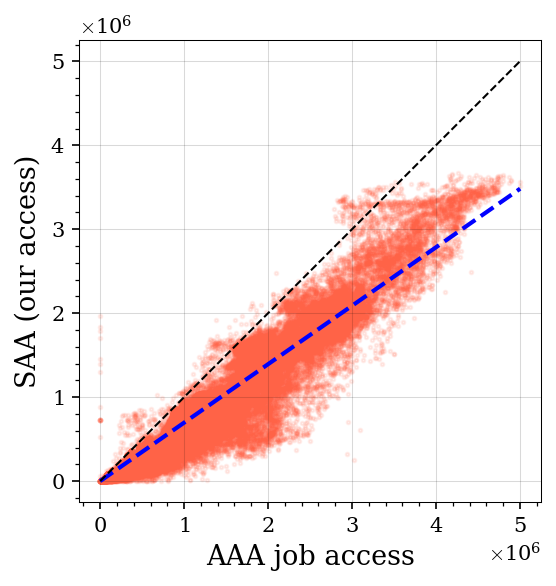

In [51]:
ax = plot(size=(6, 4), dpi=150, xlab='AAA job access', ylab='SAA (our access)')
ax.set_aspect('equal')
df = filt(xs, mode='Drive', thresh='30')
ax.scatter(df.aaa, df.saa, s=3, alpha=0.1, color='tomato')
reg = LinearRegression(fit_intercept=False).fit(df[['aaa']], df.saa)
x = np.linspace(0, df.aaa.max(), 100)
y = x * reg.coef_[0]
ax.plot(x, y, 'b--', lw=2)
ax.plot(*[[0, df.aaa.max()]] * 2, 'k--', lw=1);

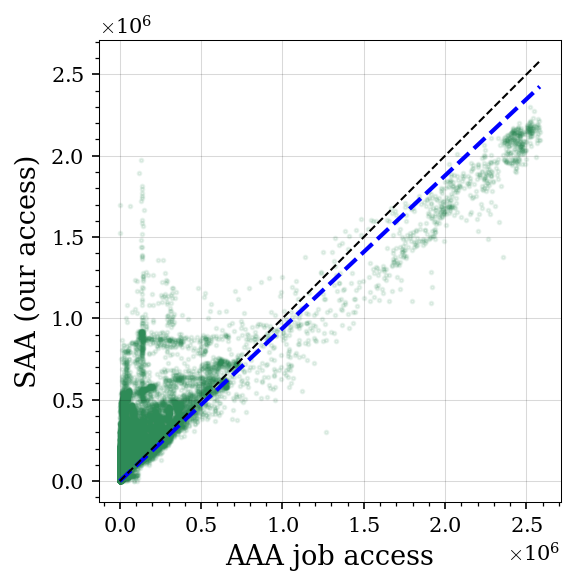

In [52]:
ax = plot(size=(6, 4), dpi=150, xlab='AAA job access', ylab='SAA (our access)')
ax.set_aspect('equal')
df = filt(xs, mode='Bike', thresh='30')
ax.scatter(df.aaa, df.saa, s=3, alpha=0.1, color='seagreen')
reg = LinearRegression(fit_intercept=False).fit(df[['aaa']], df.saa)
x = np.linspace(0, df.aaa.max(), 100)
y = x * reg.coef_[0]
ax.plot(x, y, 'b--', lw=2)
ax.plot(*[[0, df.aaa.max()]] * 2, 'k--', lw=1);